# ASSIGNMENT 3                                                McGill COMP451 - Fall 2022
Mingze Wang (260986639) - **mingze wang**


If you discussed solutions with any of your classmates please list their name here. You should not share any code with your classmates, but you can discuss your solution. This is an individual assignment. The team ID above is only needed because we need to link your report to your Kaggle submission.

**Note:** you can only use late days to submit the report (which has 5/20 pts). The competition, which is the main part of this assignment (15/20 pts), will close at the exact submission deadline. So please start early! 

## Objective
The objective of this assignment is to give you hands-on experience with deep learning packages, such as pyTorch. The task here is to build a model that takes an image as input and produces a single number. The image contains three digits consisting only of digits 1,2 and 3. The output of the model should be the product of these digits. It is up to you to choose the model architecture. You may choose to first predict each digit and then calculate their product, or calculate the product in one shot. You may approach this as a classification task since the output options are limited, or consider it as a regression task. The assignment has two deliverables: 
- you need upload your prediction for the test set to Kaggle in order to participate in the competition
- you need to complete this notebook which is considered a report of your methodolgoy

# Kaggle Competition
You get access to the Kaggle competition using the following private url
[https://www.kaggle.com/t/e4c5b440119c4116b2128e4c3dbb8e58](https://www.kaggle.com/t/e4c5b440119c4116b2128e4c3dbb8e58)
Training and test data are available as a part of the assignment in the datasets folder. To participate in the competition you should upload a CSV file containing your predicted label for the entire test data to Kaggle. 
The test data is divided in half. You receive the correct label for the first half (in datasets folder), so that you can evaluate your model in this notebook on that part of the test set. You then submit your solution for the entire test set to Kaggle. The final evaluation is based on your predictions for the second part of the test set (private leaderboard). We have step-by-step explanation in the final section of this notebook.

# Report
The purpose of this notebook is for you to provide a concise report of your methodology. That is you need to include all steps necessary to reproduce your results. Please include high level explanation of the implementation so that we can understand what you're trying to achieve in each piece of the code.

**Note:** You need to submit this notebook where you have run all the cells as part of Assignment 3. **We should not need to rerun your code since this can take a long time.** You can use your Google cloud credit towards this assignment, to get better GPU access for example, using Google colab. Ask for help if you want to do this.

## Grading (20 pts)
The grading for this assignment has two components
- **Performance in the private leaderboard** (**15 pts**)
    - Have you correctly implemented a **deep model** and correctly trained in on the dataset (**5pts**). Note that this means your solution discussed in this report has to be a deep model, implemented using automatic differentiation packages such as pyTorch, Jax or Tensorflow.
    - a linear grade based on your relative accuracy: $10 \times \frac{acc_{you}}{acc_{best}}$ -- where $acc_{best}$ is the accuracy of the best model in our class (**10pts**). So if you have 40% accuracy on the private leaderboard and the best model has 80% accuracy, you will receive $10\times \frac{40}{80} = 5$ points.
    -  Top 5 participants in the private leaderboard receive a bonuses of 10, 8, 6, 4, 2 pts. If your total grade is over 20pts your bonus will be carried over to your final grade.
- **Quality of Your Report** (**5pts**)
    - Is your report clear and concise? 
    - do you have a minimal yet clear explanation for each step? Also, if you are using routines that are trivial and can be separated into a another python file you can do this in favour of better readability and minimality of the notebook. 
    - Do your design choices make sense? Are they justified?
    - If you tried several ideas, try to focus your report on the final one that is used in your final submission. You can quickly mention what other ideas you tried and discarded if that is the case.

**Note:** if the results in the final part of this report does not match the CSV file that you uploaded to Kaggle you will not receive any points for this entire assignment.

## Step 1 - the dataset
Use the following code to load the data using the npy files. We have 11,000 training examples, where each image is 64x64. Labels are the product of numbers in each image. The label is printed at the top of each example shown below.

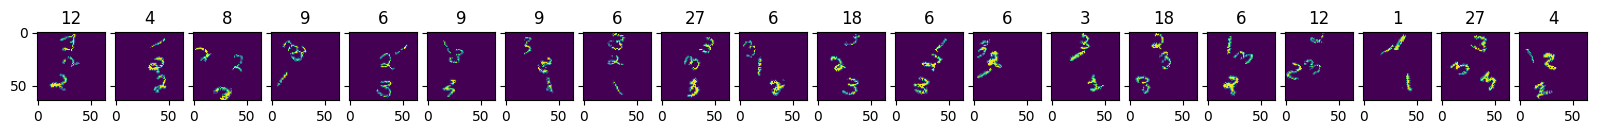

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid                         #To plot the images in grid and we have seen it befoer 

x = np.load('datasets/x_train.npy') #11,000 x 64 x 64
y = np.load('datasets/y_train.npy')
def plot_digits(x,y):
    num_plots = x.shape[0]
    fig = plt.figure(figsize=(num_plots, 10.*num_plots))
    grid = ImageGrid(fig, 111, nrows_ncols=(1, num_plots), axes_pad=0.1)
    for i in range(num_plots):
        grid[i].imshow(x[i].reshape((64,64)))
        grid[i].set_title(str(y[i]))
    plt.show()
plot_digits(x[:20], y[:20])  #plot 20 first instances in the dataset 

## Step 2 - preprocessing 

Your report should contain any potential preprocessing that you have done on the dataset. If you haven't performed any preprocessing, please leave this empty. This includes any sample code that you will use. 

## Import Packages

In [2]:
import torch
import torch.nn as nn
import torch.utils.data as tdata
import os
from sklearn.model_selection import train_test_split
from torchvision import transforms
from tqdm import tqdm
import os

# Set random seed which can improve model's performance !
seed = 3407
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = True

/home/szc8402/.conda/envs/prefix-tuning/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Build PyTorch Dataset
Since this dataset stems from MNIST dataset, I decide to split each image in this dataset into there images, and I can extend my dataset.

In [3]:
# your code here
class CustomDataset(tdata.Dataset):
    
    def __init__(self, root_path, mode):
        self.mode = mode
        x_path = os.path.join(root_path, 'x_%s.npy' % (self.mode if self.mode != 'valid' else 'test'))
        y_path = os.path.join(root_path, 'y_%s.npy' % (self.mode if self.mode != 'valid' else 'test'))
        x = np.load(x_path).astype(np.uint8) #11,000 x 64 x 64
        y = np.load(y_path)
        if self.mode == 'test':
            self.data, self.label = x, y
        elif self.mode == 'train':
            self.data, self.label = x, y
        else:
            self.data, self.label = x[:4500], y[:4500]

        self.transform = transforms.Compose([
                                            transforms.ToPILImage(),
                                            transforms.FiveCrop((28, 28)),
                                            transforms.Lambda(lambda crops: torch.stack([
                                                transforms.Normalize([0.5], [0.5])(transforms.ToTensor()(crop)) 
                                                for crop in crops])),
                                        ])
    
    def __getitem__(self, idx):
        if self.mode == 'test':
            if idx < 4500:
                return self.transform(self.data[idx]), int(self.label[idx])
            else:
                return self.transform(self.data[idx]), 0
        return self.transform(self.data[idx]), self.label[idx]
    
    def __len__(self):
        return len(self.data)


data_dir = 'datasets'
train_dataset = CustomDataset(data_dir, 'train')
valid_dataset = CustomDataset(data_dir, 'valid')
test_dataset = CustomDataset(data_dir, 'test')

# Step 3 - the model and its training
This is the main part of your report. Below we provide an example, where we apply a logistic regression model to the dataset, and we get a very bad accuracy. You can do much better! You also have to use a deep learning package in your solution. Provide the explanation for your model and its training below. 

## 3.1 example code (not using pyTorch)
The code below shows the performance of a logistic regression model which will be used as a base model in this case. 

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')
features = x.reshape(11000,-1) #vectorizing the input image
labels = y.reshape(-1,1)
x_train, x_val, y_train, y_val = train_test_split(features, labels, test_size=0.33, random_state=42) #set aside for validation
clf = LogisticRegression()
clf.fit(x_train,y_train)
predictions = clf.predict(x_val)
accuracy = accuracy_score(y_val, predictions)
print("The validation accuracy of the model is", accuracy*100, '%')

The validation accuracy of the model is 16.225895316804408 %


## 3.2 your model!

 You should choose the final learning model that you have used to submit your solutions to Kaggle. For your chosen model provide the implementation code in this notebook along with the detail. Details should include the architecture and the choice of hyperparameters. If you performed a hyperparameter search you should explain it here.

you can start here in the same cell!


# Build a ResNet


In [5]:
## your implementation goes here!
class Block(nn.Module):
    def __init__(self, num_layers, in_channels, out_channels, identity_downsample=None, stride=1):
        assert num_layers in [18, 34, 50, 101, 152], "should be a a valid architecture"
        super(Block, self).__init__()
        self.num_layers = num_layers
        if self.num_layers > 34:
            self.expansion = 4
        else:
            self.expansion = 1
        # ResNet50, 101, and 152 include additional layer of 1x1 kernels
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(out_channels)
        if self.num_layers > 34:
            self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        else:
            # for ResNet18 and 34, connect input directly to (3x3) kernel (skip first (1x1))
            self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample

    def forward(self, x):
        identity = x
        if self.num_layers > 34:
            x = self.conv1(x)
            x = self.bn1(x)
            x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x
    

class ResNet(nn.Module):
    def __init__(self, num_layers, block, image_channels, num_classes):
        assert num_layers in [18, 34, 50, 101, 152], f'ResNet{num_layers}: Unknown architecture! Number of layers has ' \
                                                     f'to be 18, 34, 50, 101, or 152 '
        super(ResNet, self).__init__()
        if num_layers < 50:
            self.expansion = 1
        else:
            self.expansion = 4
        if num_layers == 18:
            layers = [2, 2, 2, 2]
        elif num_layers == 34 or num_layers == 50:
            layers = [3, 4, 6, 3]
        elif num_layers == 101:
            layers = [3, 4, 23, 3]
        else:
            layers = [3, 8, 36, 3]
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNetLayers
        self.layer1 = self.make_layers(num_layers, block, layers[0], intermediate_channels=64, stride=1)
        self.layer2 = self.make_layers(num_layers, block, layers[1], intermediate_channels=128, stride=2)
        self.layer3 = self.make_layers(num_layers, block, layers[2], intermediate_channels=256, stride=2)
        self.layer4 = self.make_layers(num_layers, block, layers[3], intermediate_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * self.expansion, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return x

    def make_layers(self, num_layers, block, num_residual_blocks, intermediate_channels, stride):
        layers = []

        identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels, intermediate_channels*self.expansion, kernel_size=1, stride=stride),
                                            nn.BatchNorm2d(intermediate_channels*self.expansion))
        layers.append(block(num_layers, self.in_channels, intermediate_channels, identity_downsample, stride))
        self.in_channels = intermediate_channels * self.expansion # 256
        for i in range(num_residual_blocks - 1):
            layers.append(block(num_layers, self.in_channels, intermediate_channels)) # 256 -> 64, 64*4 (256) again
        return nn.Sequential(*layers)


## Training Procedure

In [13]:
num_classes = 28
num_epochs = 8
batch_size = 64
learning_rate = 1e-4

# 18, 34, 50, 101, 152
num_layers = 34
model = ResNet(num_layers, Block, 1, num_classes)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = 0.001, betas=(0.9, 0.999), amsgrad=False) 

# build dataloader
train_dataloader = tdata.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = tdata.DataLoader(valid_dataset, batch_size=batch_size)
test_dataloader = tdata.DataLoader(test_dataset, batch_size=10)

In [14]:
# Train

model = model.to('cuda')

for epoch in range(num_epochs):
    for step, (data, labels) in enumerate(train_dataloader):
        data = data.to('cuda')
        bs, ncrops, c, h, w = data.size()
        data = data.view(-1, c, h, w)
        labels = labels.to('cuda').view(-1, )
        optimizer.zero_grad()
        outputs = model(data).view(bs, ncrops, -1).mean(1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    total_loss = 0.0
    preds = None
    all_labels = None
    with torch.no_grad():
        for data, labels in valid_dataloader:
            data = data.to('cuda')
            bs, ncrops, c, h, w = data.size()
            data = data.view(-1, c, h, w)
            labels = labels.to('cuda').view(-1, )
            outputs = model(data).view(bs, ncrops, -1).mean(1)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            outputs = torch.argmax(outputs, dim=-1).reshape(-1, 1)
            if preds == None:
                preds = outputs.to('cpu')
                all_labels = labels.reshape(-1, 1).to('cpu')
            else:
                preds = torch.cat([preds, outputs.to('cpu')], dim=0)
                all_labels = torch.cat([all_labels, labels.reshape(-1, 1).to('cpu')], dim=0)
        acc = (preds == all_labels).sum() / preds.shape[0]
        print('Valiation accuracy is %.2f' % acc)
        print('Epoch %d validation loss: %.2f' % (epoch, total_loss / len(valid_dataloader)))
                
        
    

Valiation accuracy is 0.34
Epoch 0 validation loss: 1.86
Valiation accuracy is 0.52
Epoch 1 validation loss: 1.49
Valiation accuracy is 0.67
Epoch 2 validation loss: 1.13
Valiation accuracy is 0.77
Epoch 3 validation loss: 0.80
Valiation accuracy is 0.81
Epoch 4 validation loss: 0.62
Valiation accuracy is 0.83
Epoch 5 validation loss: 0.53
Valiation accuracy is 0.87
Epoch 6 validation loss: 0.40
Valiation accuracy is 0.91
Epoch 7 validation loss: 0.27


# Step 4 - accuracy metrics and CSV submission to Kaggle

Here you can report accuracy metrics for the training and test sets. If you set aside a validation set you can report your accuracy on that set. Other plots such as training-validation loss plot over the training period can also be interesting to see here. A minimum here is the accuracy on the first half of the test set. **this number should match your public leaderboard accuracy**. If this is not the case then your predictions here do not match what you reported on Kaggle and your submission is discarded! This is because otherwise we can't establish that this code was used to produce the result of the leaderboard. Below we show this minimal report for the logistic regression classifier that we trained above.

## Prediction Procedure

In [10]:
# >>> your code printing the test error on x_test_half
with torch.no_grad():
    avail_preds = None
    avail_labels = None
    all_preds = None
    for data, labels in test_dataloader:
        data = data.to('cuda')
        bs, ncrops, c, h, w = data.size()
        data = data.view(-1, c, h, w)
        labels = labels.to('cuda')
        outputs = model(data).view(bs, ncrops, -1).mean(1)
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        outputs = torch.argmax(outputs, dim=-1).reshape(-1, 1)
        if all_preds == None:
            all_preds = outputs.to('cpu')
            avail_preds = outputs.to('cpu')
            avail_labels = labels.reshape(-1, 1).to('cpu')
        else:
            all_preds = torch.cat([all_preds, outputs.to('cpu')], dim=0)
            if avail_labels.shape[0] < 4500:
                avail_preds = torch.cat([avail_preds, outputs.to('cpu')], dim=0)
                avail_labels = torch.cat([avail_labels, labels.reshape(-1, 1).to('cpu')], dim=0)
        
acc = (avail_preds == avail_labels).sum() / avail_preds.shape[0]
print('Half test accuracy is %.2f' % acc)    

# <<< your code here

Half test accuracy is 0.91


In order to submit your results to Kaggle you need to provide your predictions in CSV format. The code below shows how we do this for the example of logistic regression above. You can use the same method for your submission. Note that we need you to submit your result for the **entire test set** of size 9000. Your accuracy on the first half will show on the public leaderboard and the second half is on the private leaderboard that will be revealed when the competition is over. Submit the `predicted_labels.csv` to the Kaggle competition!  

In [17]:
# import pandas as pd #you need to install pandas - also checkout what this package is good for while at it :]
# def generate_csv_kaggle(y):
#     indexes = np.arange(len(y))
#     csv_labels = np.concatenate((indexes.reshape(-1,1), y.reshape(-1,1)),axis=1)
#     df = pd.DataFrame(csv_labels,columns=['Id','Category'])
#     df['Id'] = df['Id'].astype(str)
#     df['Category'] = df['Category'].astype(str)
#     df.to_csv('predicted_labels.csv',index=False)
#     pass

# yh_test = clf.predict(np.reshape(x_test, (9000,-1))) #prediction of the model for the entire training set
# generate_csv_kaggle(yh_test)

In [16]:
import pandas as pd #you need to install pandas - also checkout what this package is good for while at it :]
def generate_csv_kaggle(y):
    indexes = np.arange(len(y))
    csv_labels = np.concatenate((indexes.reshape(-1,1), y.reshape(-1,1)),axis=1)
    df = pd.DataFrame(csv_labels,columns=['Id','Category'])
    df['Id'] = df['Id'].astype(str)
    df['Category'] = df['Category'].astype(str)
    df.to_csv('predicted_labels.csv',index=False)
    pass

# Combine correct answers to Half of test dataset with my predictions of the rest of the test data
preds = all_preds.numpy()
generate_csv_kaggle(preds)